#**Tutorial # 5 : Radiative Convective Equilibrium**


**Week 1, Day 5, Climate Modeling**

**Content creators:** Jenna Pearson, Brodie Pearson, and Abigail Bodner

**Content reviewers:** TBD

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD



#**Tutorial Objectives**

In this tutorial students will learn about radiative-equilibrium and radiative-convective-equilibrium. Much of the code shown here was taken from [The Climate Labratory](https://brian-rose.github.io/ClimateLaboratoryBook/home.html) by Brian Rose. Students are encouraged to visit this website for more tutorials and background on these models.

By the end of this tutorial students will be able to:
* Implement both of these types of models using the python package climlab
* Understand how these models build off of the energy balance model of the previous tutorials.

# Setup

## Package Installations


In [1]:
# # note the conda install takes quite a while, but conda is REQUIRED to properly download the dependencies (that are not just python packages)
# !pip install condacolab &> /dev/null           # need to use conda installation of climlab, pip won't work. condacolab is a workaround
# import condacolab
# condacolab.install()
# !mamba install -c anaconda cftime xarray numpy &> /dev/null    # for decoding time variables when opening datasets
# !mamba install -c conda-forge metpy climlab &> /dev/null

## Package Imports

In [2]:
# I have to run this twice to get it to work...not idea why

import xarray as xr                     # used to manipulate data and open datasets
import numpy as np                      # used for algebra/arrays
import urllib.request                   # used to download data from the internet
import climlab                          # one of the models we are using
import matplotlib.pyplot as plt         # used for plotting
import metpy                            # used to make Skew T Plots of temperature and pressure
from metpy.plots import SkewT           # plotting function used widely in climate science

/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/climlab/radiation/cam3.py:46: UserWarning: Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, CAM3 module will not be functional.')
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/climlab/radiation/rrtm/rrtmg_lw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_LW module will not be functional.')
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/climlab/radiation/rrtm/rrtmg_sw.py:19: UserWarning: Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.
  warnings.warn('Cannot import and initialize compiled Fortran extension, RRTMG_SW module will not be functional.')


## Helper Functions

In [3]:
#  Some imports needed to make and display animations in Part 4
from IPython.display import HTML
from matplotlib import animation

# these three functions are used to make videos at the end of the tutorial

def initial_figure(model):
    fig = plt.figure(figsize=(6,6))
    lines = []
    
    skew = SkewT(fig,rotation=30)
    #  plot the observations
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')    
    lines.append(skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='RC model (all gases)')[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    lines[1].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    #lines[2].set_xdata(np.array(model.q)*1E3)
    # lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

## Figure Settings

In [4]:
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# Lecture

In [5]:
# tech will add video later

# Section 1: Setting up a Radiative Equilibrium Model Using Climlab



The energy balance model we have used so far is zero dimensional, yielding only a global mean surface temperature. We might then ask, is it possible to construct a model for an *atmospheric column*, and see the influence on the temperature *profile*. Additionally, can we explicity include individual gases in this model, rather than just parametrizing their collective effects through $\tau$? The answer is yes we can! 

 We are not going to construct this model from scratch as we did in the previous tutorials but will use a model already available from the python package [climlab](https://climlab.readthedocs.io/en/latest/intro.html). 
 
**Radiative equilibrium models** consider different layers of the atmosphere. These all interact with each other and the model is able to directly calculate the radiation budget as energy is transfered between atmospheric layers and Earth's surface. **Radiative equilibrium** is reached when all the layers gain and lose energy at the same rate. Analyzing the temeprature profile once the model has reached equilibrium will be our task throughout this tutorial.

To set up this model, we will need some information about the mean properties of the atmosphere. We are going to download water vapor data from the Community Earth System Model, a global climate model that we will go into detail on in the next tutorial, to use a variable called [specific humidity](https://glossary.ametsoc.org/wiki/Specific_humidity). **Specific humidity** is the mass of water vapor per mass of a unit block of air, and gives us information about water vapor, an important greenhouse gas.

Two ways to do this, manually downloading data and accessing from drive, or accessing via the internet.


In [6]:
# use xarray to open the dataset - this can take a long time!
import pooch, os

fname = "cpl_1850_f19-Q-gw-only.cam.h0.nc"
if not os.path.exists(fname):
    url = "https://osf.io/c6q4j/download/"
    fname = pooch.retrieve(
        url,
        known_hash=None
    )
ds = xr.open_dataset(fname) # ds = dataset


# the specific humidity is stored in the variable called Q
ds.Q

<xarray.DataArray 'Q' (time: 240, lev: 26, lat: 96, lon: 144)>
[86261760 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0001-02-01 00:00:00 ... 0021-01-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

In [7]:
# # download from the internet
# # note it takes a few minutes to download the file.

# # define website name
# url = f'http://thredds.atmos.albany.edu:8080/thredds/fileServer/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc'

# # take just the last part of the website name after the last '/' as the filename
# savename = url.split('/')[-1]

# # get the file
# urllib.request.urlretrieve(url,savename)

# # use xarray to open the dataset
# ds = xr.open_dataset(savename) # ds = dataset

# # the specific humidity is stored in the variable called Q
# ds.Q

We need to use python to convert this 3-dimensional field into a global, annual average profile.

In [8]:
# take global, annual average
weight_factor = ds.gw / ds.gw.mean(dim='lat')
Qglobal = (ds.Q * weight_factor).mean(dim=('lat','lon','time'))
# print specific humidity profile
Qglobal

<xarray.DataArray (lev: 26)>
array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

Now that we have this data, we can define a model that has the same vertical levels as this data does.

In [9]:
# use 'lev=Qglobal.lev' to create an identical vertical grid to water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

The specific radiation model we are choosing is the **[Rapid Radiative Transfer Model](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html)**. This is given by the 'RRTMG'. Below, we will initialize our model.

In [10]:
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

Let's explore this initial state. Here $T_s$ is the initial global mean surface temperature, and $T_{atm}$ is the initial global mean air temperature profile.

In [11]:
radmodel.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

One of the perks of using this model is it's ability to incorporate the spectral effects of individual greenhouse gases, rather than a bulk reduction in transmission of outgoing longwave radiation in our previous model.

Displaying 'absorber_vmr' gives the **volume mixing ratio**'s stored in our model for each included gas. The volume mixing ratio is percentage of molecules in the atmosphere that are a given gas . For example, $21\%$ of air is oxygen and so it's volumn mixing ratio is 0.21.

In [12]:
radmodel.absorber_vmr

{'CO2': 0.000348,
 'CH4': 1.65e-06,
 'N2O': 3.06e-07,
 'O2': 0.21,
 'CFC11': 0.0,
 'CFC12': 0.0,
 'CFC22': 0.0,
 'CCL4': 0.0,
 'O3': array([7.52507018e-06, 8.51545793e-06, 7.87041289e-06, 5.59601020e-06,
        3.46128454e-06, 2.02820936e-06, 1.13263102e-06, 7.30182697e-07,
        5.27326553e-07, 3.83940962e-07, 2.82227214e-07, 2.12188506e-07,
        1.62569291e-07, 1.17991442e-07, 8.23582543e-08, 6.25738219e-08,
        5.34457156e-08, 4.72688637e-08, 4.23614749e-08, 3.91392482e-08,
        3.56025264e-08, 3.12026770e-08, 2.73165152e-08, 2.47190016e-08,
        2.30518624e-08, 2.22005071e-08])}

To look at CO2 in a more familiar unit, parts per million (by volume), we can convert and print the new value.

In [13]:
radmodel.absorber_vmr['CO2'] * 1E6

348.0

We can also look at all the available diagnostics of our model:

In [14]:
climlab.to_xarray(radmodel.diagnostics)

<xarray.Dataset>
Dimensions:           (depth: 1, depth_bounds: 2, lev: 26, lev_bounds: 27)
Coordinates:
  * depth             (depth) float64 1.25
  * depth_bounds      (depth_bounds) float64 0.0 2.5
  * lev               (lev) float64 3.545 7.389 13.97 ... 929.6 970.6 992.6
  * lev_bounds        (lev_bounds) float64 0.0 5.467 10.68 ... 950.1 981.6 1e+03
Data variables: (12/26)
    OLR               (depth) float64 0.0
    OLRclr            (depth) float64 0.0
    OLRcld            (depth) float64 0.0
    TdotLW            (lev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TdotLW_clr        (lev) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    LW_sfc            (depth) float64 0.0
    ...                ...
    SW_flux_up        (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_down      (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_net       (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_up_clr    (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_down_clr  (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SW_flux_net_clr   (lev_bounds) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

For example to look at OLR,

In [15]:
radmodel.OLR

Field([0.])

Note it is currently set to 0 as we have no ran the model forward in time yet.

## Questions

1.  Why do you think all gases except ozone and water vapor are single values?

## Coding Exercises

1.  On the same graph, plot the annual mean specific humidty profile and ozone profiles.

In [16]:
# fig, ax = plt.subplots()
# #  multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
# ax.plot(..., ...)

# # pressure decreases logarithmically with heigh in the atmosphere
# # invert the axis so the largest value of pressure is lowest
# ax.invert_yaxis()
# # set y axis to a log scale
# plt.yscale('log')

# ax.set_ylabel('Pressure (hPa)')
# ax.set_xlabel('Specific humidity (g/kg)')

# # turn on the grid lines
# ax.grid()

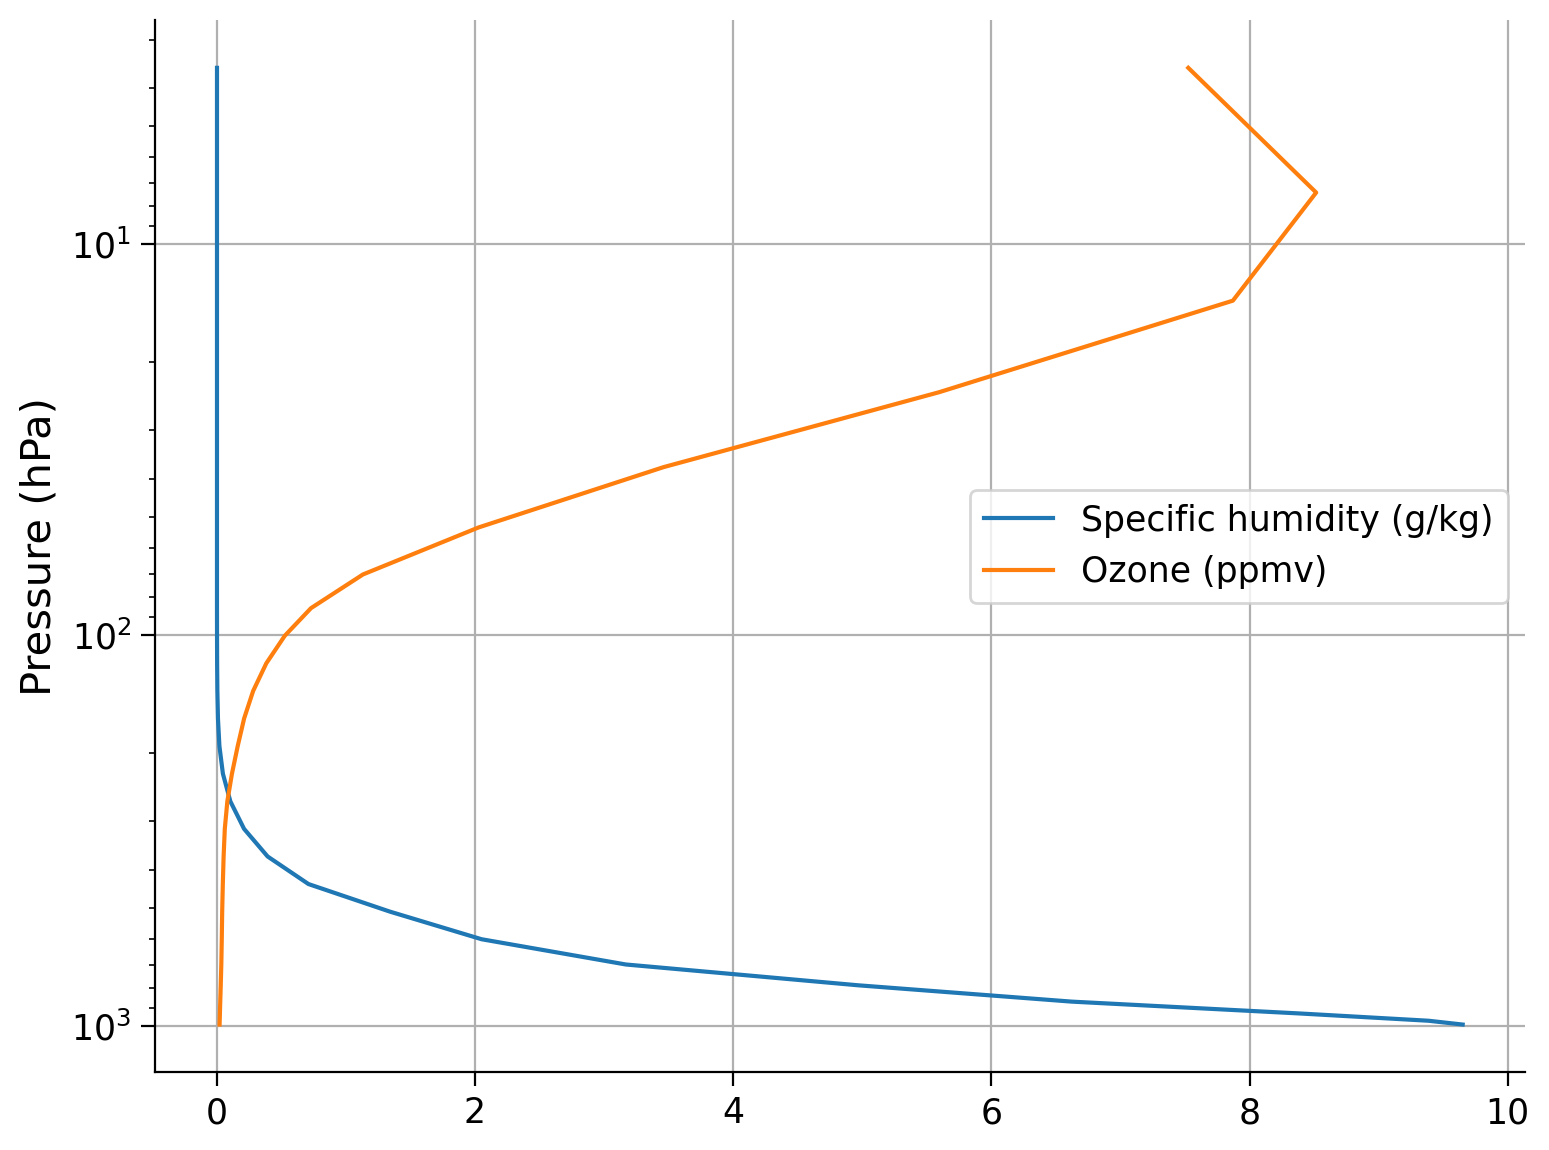

In [17]:
# to_remove solution

fig, ax = plt.subplots()
# multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev, label = 'Specific humidity (g/kg)')
# multiply by 1E6 to get units of ppmv = parts per million by volume
ax.plot(radmodel.absorber_vmr['O3']*1E6,radmodel.lev, label = 'Ozone (ppmv)')

# pressure decreases logarithmically with height in the atmosphere
# invert the axis so the largest value of pressure is lowest
ax.invert_yaxis()
# set y axis to a log scale
plt.yscale('log')

ax.set_ylabel('Pressure (hPa)')

# turn on the grid lines
ax.grid()

# turn on legend
plt.legend()

# Section 2: Getting Data to Compare to the Model

Before we run our model forward, we will download a reanalysis product from NCEP to get a sense of what the global mean atmospheric tempaerture profile looks like. We will compare this profile to our model runs later.

In [18]:
# use xarray to open the dataset - this can take a long time!
# fname = 'air.mon.1981-2010.ltm.nc'
url = "https://osf.io/w6cd5/download/"
data_path = pooch.retrieve(
    url,
    known_hash=None
)
ncep_air = xr.open_dataset(data_path) # ds = dataset

# this is the long term monthly means
ncep_air.air

SHA256 hash of downloaded file: e653932e5153d1b06f04eff66b788014b5d9f4aa1f8fe0f954077e5c79f2c183
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/wesleybanfield/miniconda3/envs/pangeo/lib/python3.10/site-packages/xarray/coding/times.py:154: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with

<xarray.DataArray 'air' (time: 12, level: 17, lat: 73, lon: 144)>
[2144448 values with dtype=float32]
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 0001-01-01 00:00:00 ... 0001-12-01 00:00:00
Attributes:
    long_name:     Monthly Long Term Mean of Air temperature
    units:         degC
    precision:     2
    var_desc:      Air Temperature
    level_desc:    Pressure Levels
    statistic:     Long Term Mean
    parent_stat:   Mean
    valid_range:   [-200.  300.]
    actual_range:  [-89.722336  41.616005]
    dataset:       NCEP Reanalysis Derived Products

In [19]:
# # download the data from the internet
# url = f'https://downloads.psl.noaa.gov/Datasets/ncep.reanalysis/Monthlies/pressure/air.mon.1981-2010.ltm.nc'
# savename = url.split('/')[-1]
# urllib.request.urlretrieve(url,savename)
# ncep_air = xr.open_dataset(savename) # ds = dataset

# # this is the long term monthly means
# ncep_air.air

In [20]:
# need to take the average over space and time
# the grid cells are not the same size moving towards the poles, so we weight by the cosine of latitude to compensate for this 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')

Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))
Tglobal

<xarray.DataArray (level: 17)>
array([ 15.179084  ,  11.207003  ,   7.8383274 ,   0.21994135,
        -6.4483433 , -14.888848  , -25.570469  , -39.36969   ,
       -46.797905  , -53.652245  , -60.56356   , -67.006065  ,
       -65.53293   , -61.48664   , -55.853584  , -51.593952  ,
       -43.21999   ], dtype=float32)
Coordinates:
  * level    (level) float32 1e+03 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0

Below we will define two helper funcitons to visualize the profiles output from our model with a 'SkewT' plot. This is common way to plot atmospheric temperture in climate science, and the metpy package has a built in function to make this easier.



In [21]:
# to setup the skewT and plot observations
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    # skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

In [22]:
# to add a model derived profile to the skewT figure
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

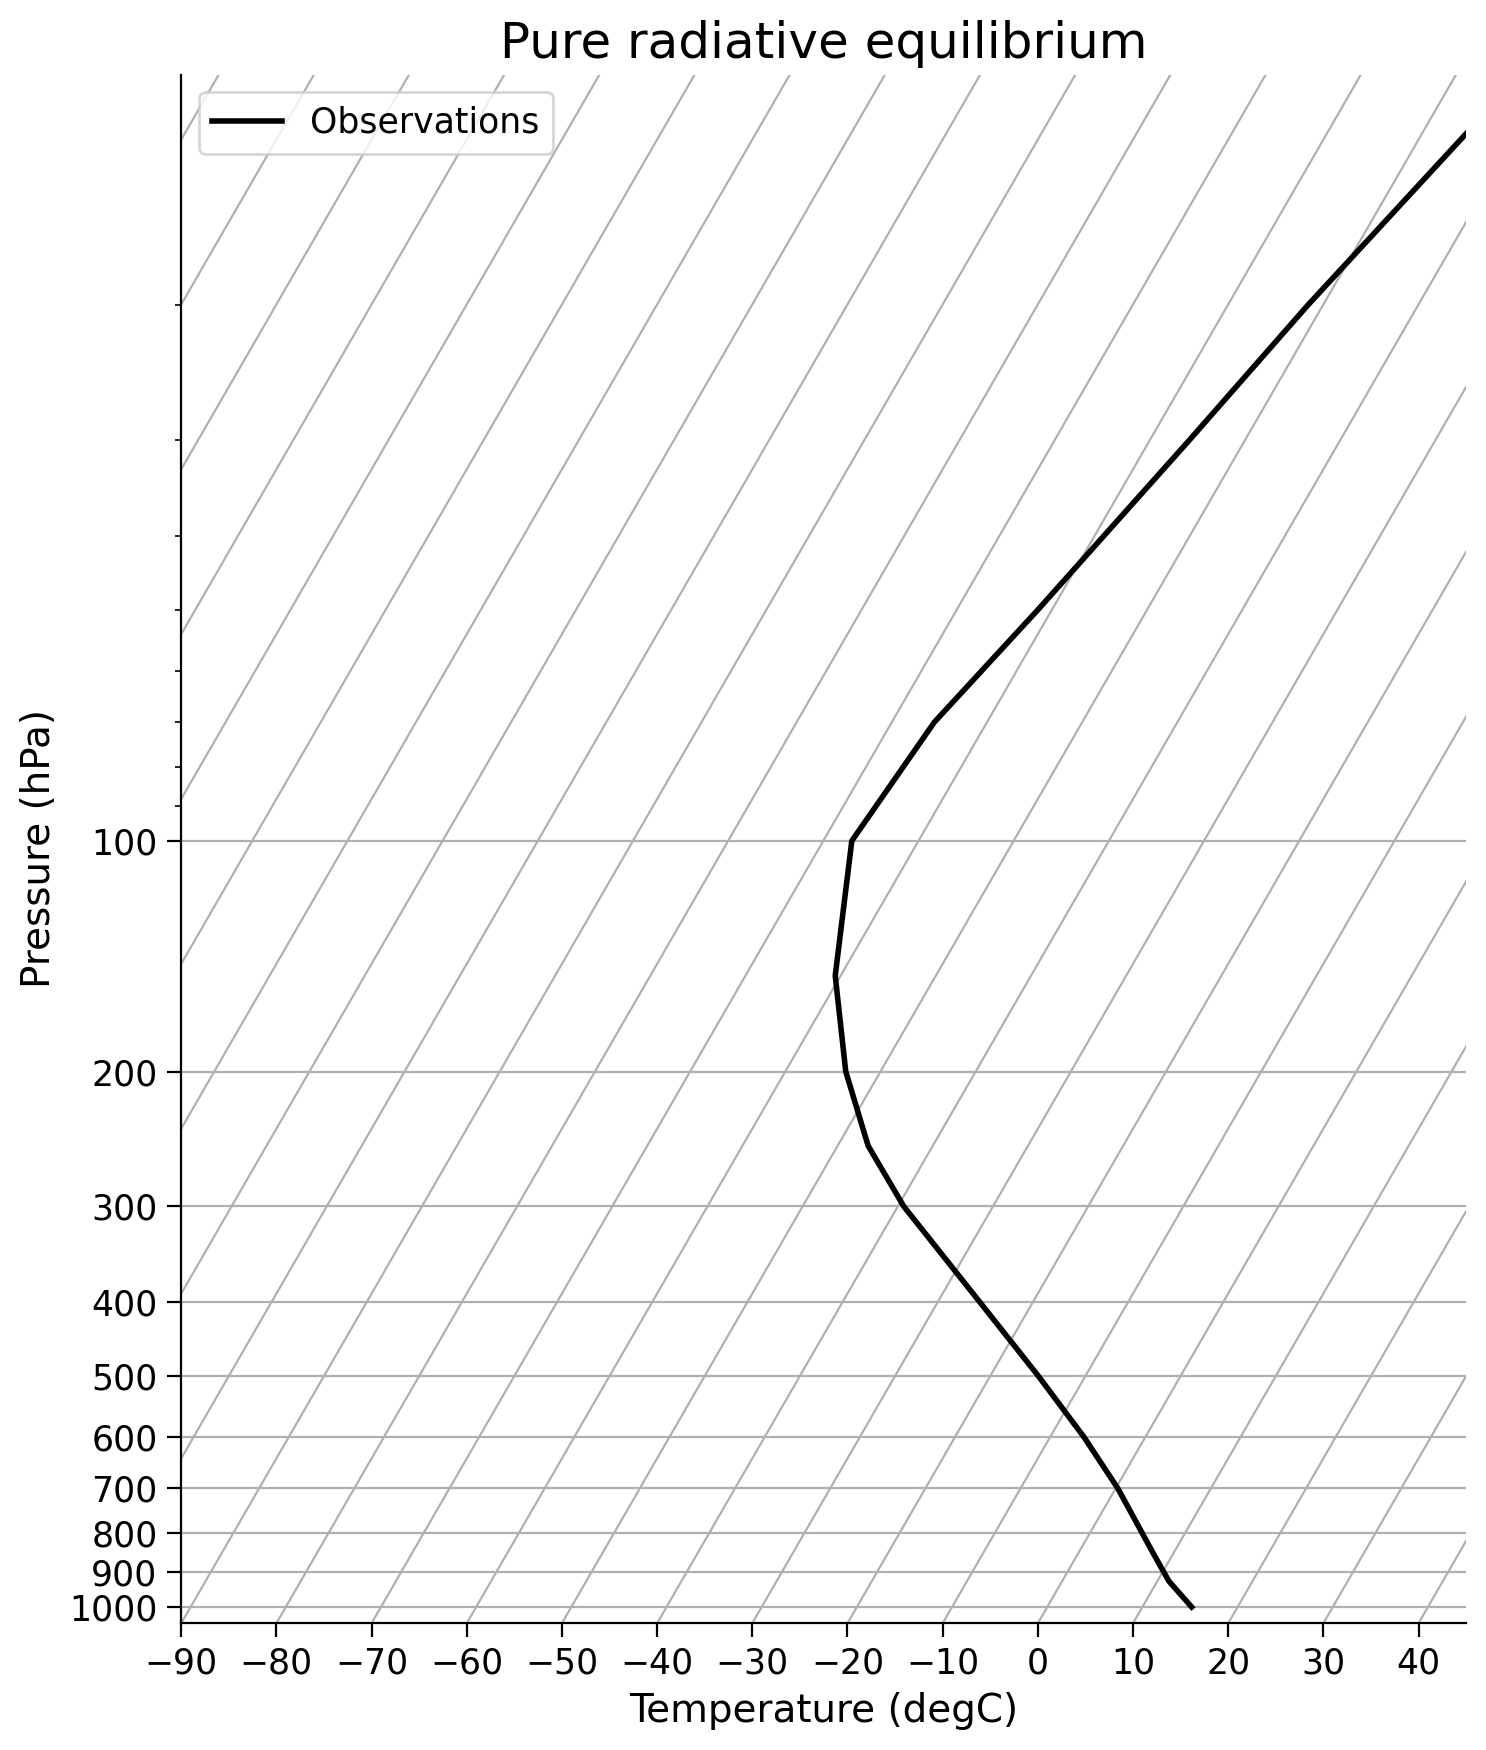

In [23]:
skew = make_skewT()
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

SkewT (also known as SkewT-logP) plots are generally used for much [more complex reasons](https://www.weather.gov/source/zhu/ZHU_Training_Page/convective_parameters/skewt/skewtinfo.html) than we will use here. However, one of the niceties of this plot that we will take advantage of is the fact that pressure decreases approximately logarithmically with height. This with a 'logP' axis, we are showing information that is linear in height and more sensible to intuit. 

# Section 3 : Running the Radiative Equilibrium Model Forward in Time

Just as with the simple greenhouse model, we wish to run this model over many time steps and examine the behavior of the temperature column after a long time. 

There is no need to write out a function to step our model forward - climlab already has this feature. We will use this function to run our model to equilibrium, that is when OLR is balanced by ASR.

In [25]:
# take a single step forward to the diagnostics are updated and there is some energy imbalance
radmodel.step_forward()

# run the model to equilibrium (the difference between ASR and OLR is a very small number)
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

NameError: name '_rrtmg_sw' is not defined

In [ ]:
#  check the energy budget to make sure we are really at equilibrium
radmodel.ASR - radmodel.OLR

Field([0.00988074])

Now we can compare this to observations.

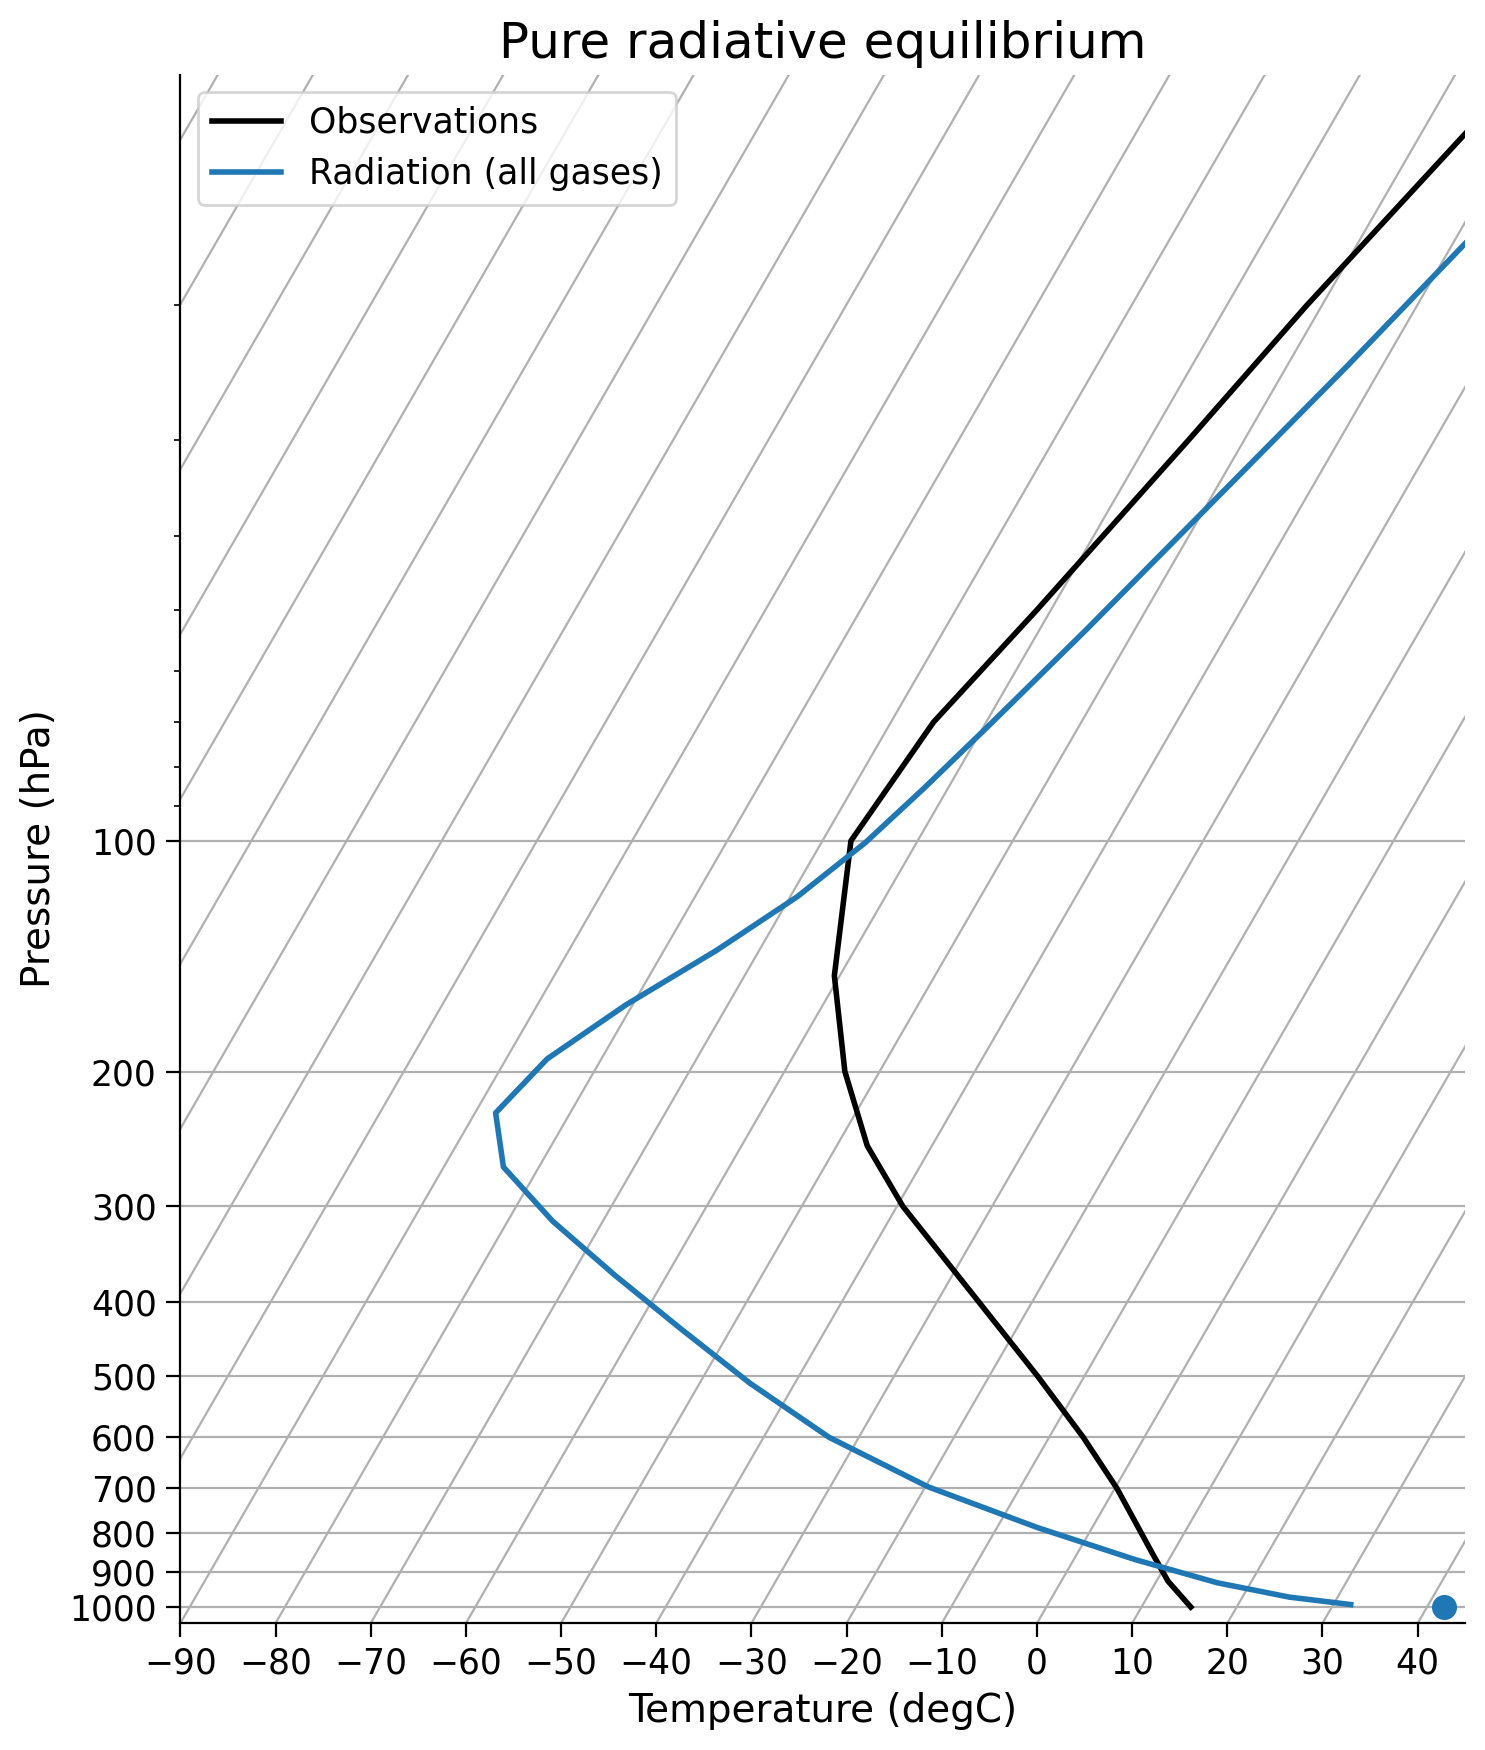

In [ ]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);
















## Questions

1. What effect do you think the individual gases play in determining this profile and why?
2. The profile from our model does not match observations well. Can you think of one component we might be missing?

## Coding Exercises

1. Create a second model called 'Radiation (no H20)' that lacks water vapor. Then re-create the plot above, but add on this extra profile without water vapor.

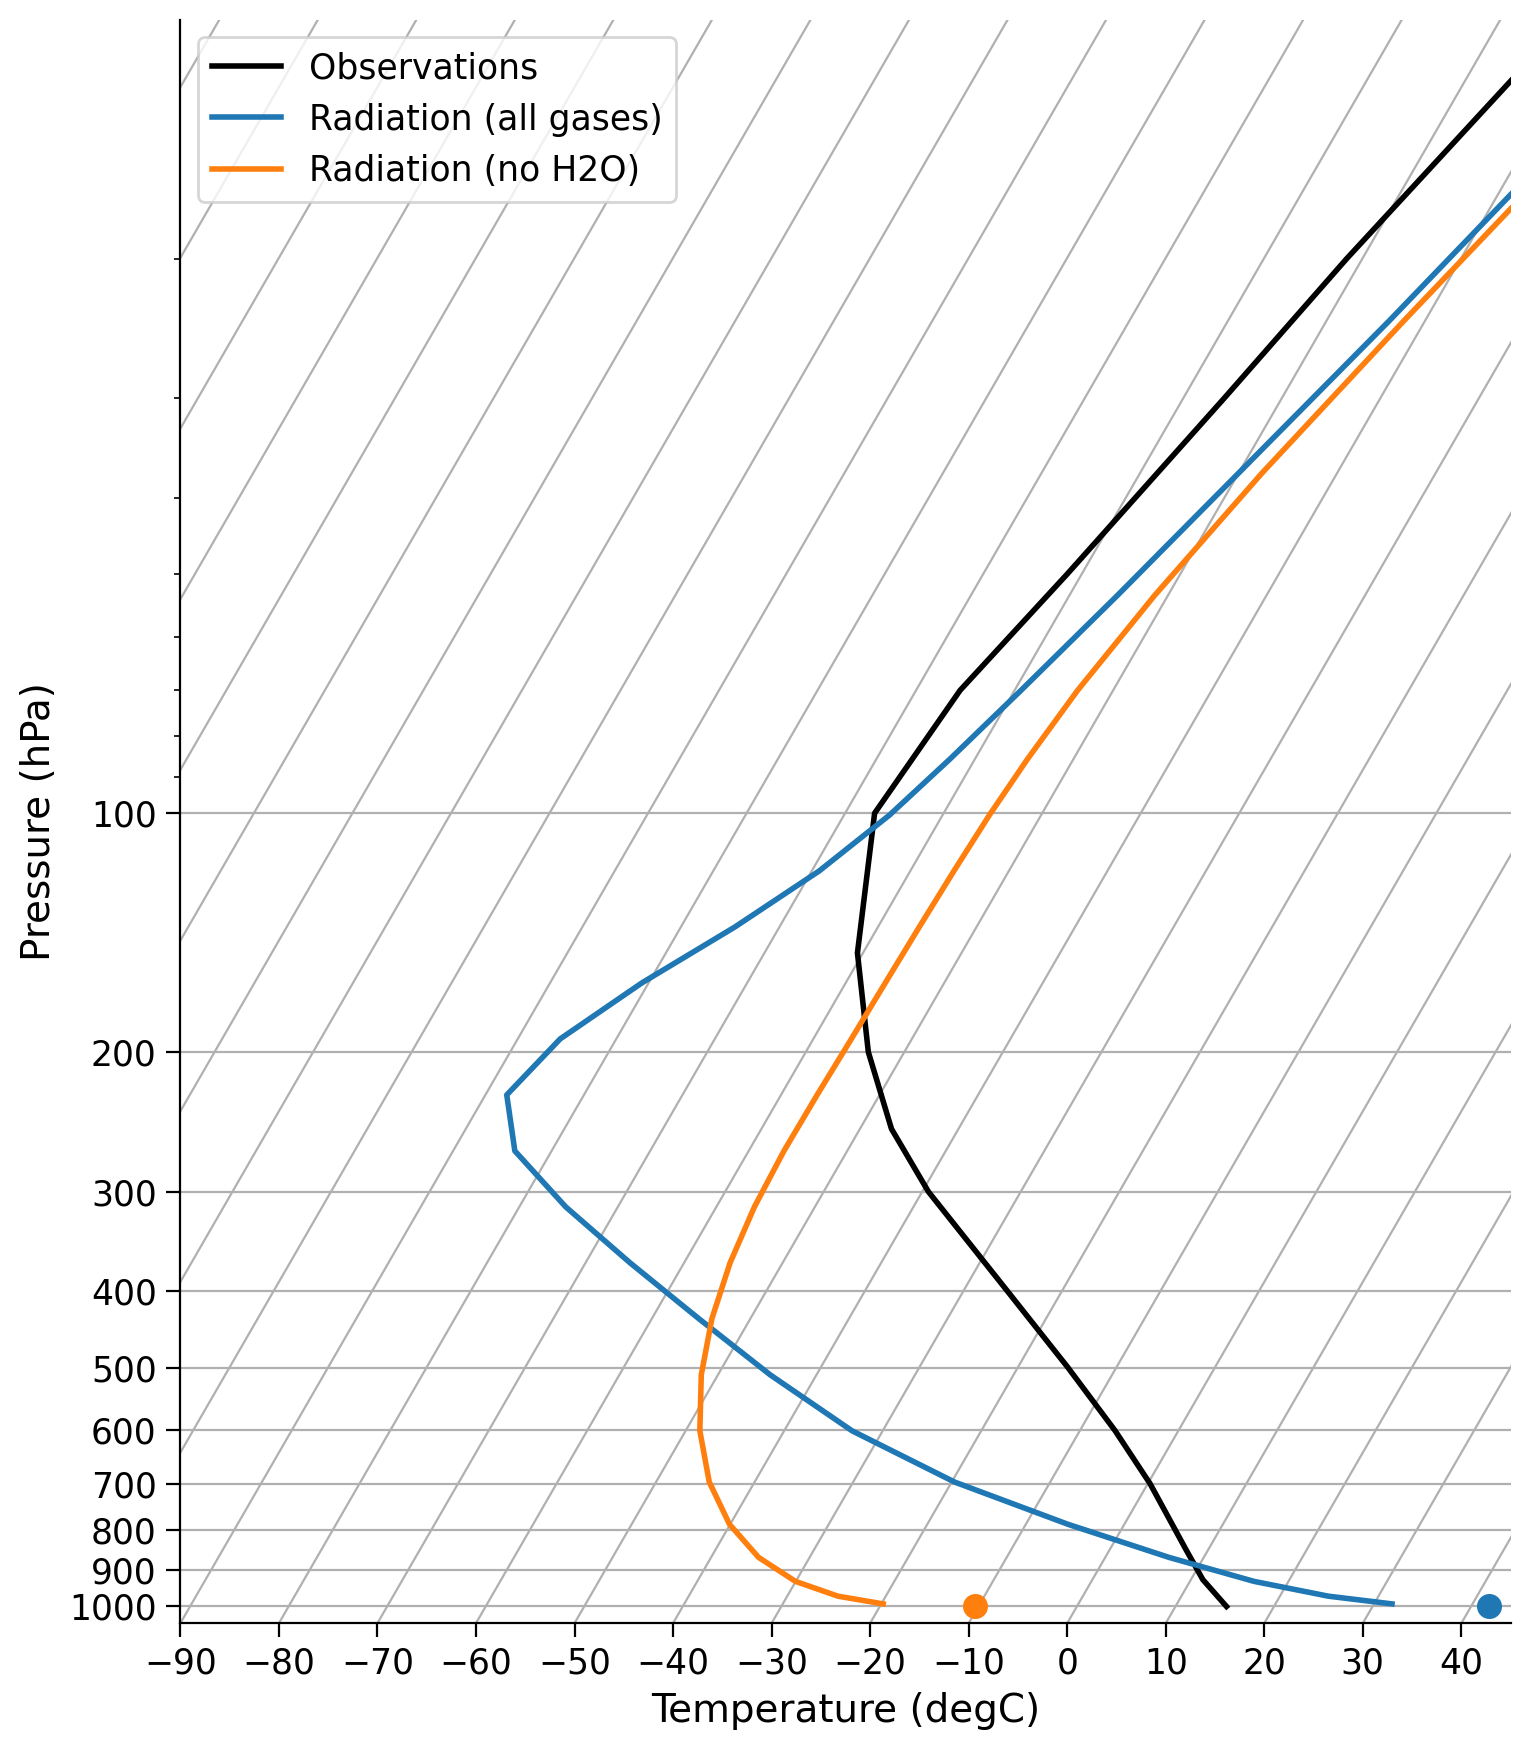

In [ ]:
# to_remove solution

# make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
# change the name of our new model
radmodel_noH2O.name = 'Radiation (no H2O)'

# set the water vapor profile to all zeros
radmodel_noH2O.specific_humidity *= 0.

# run the model to equilibrium
radmodel_noH2O.step_forward()
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

# Section 4 : Radiative-Convective Equilibrium

From the plot you just made, one of the largest differences between the observations and (all gases) pure radiation model lies in the lower atmosphere, where the surface air temperature is 20 degrees too warm and the 200 hPa pressure surface is 40 degrees too cold. What could be the issue?

One thing we have not included in our model yet is physics (motion of the air). The model's tempearture profile is what's known as **statically unstable** (note this definition of stability is different than that used in the previous tutorials).

Here **static** means not due to wind or other motion, and **unstable** means the air column is prone to turbulence. Turbulence mixes air, and is heavily present throughout the **troposphere**, which is roughly the first 10km of the atmosphere. This is unsurprising, as 'tropo' means 'turning', and as expected most of the weather we experience lies in this sphere. 

The type of turbulence temperature profiles like this generate is called **convective turbulence**. Think about boiling water, and the convective circulation introduced from heating water from below. 

When air is lifted [adiabatically](httphttps://forecast.weather.gov/glossary.php?word=adiabatics://), it expands and cools from the lower pressure it experiences as it rises in the atmosphere.  The *rate* of cooling depends on whether the air is saturated or not. When air is unsaturated, it cools following the dry adiabats for a given inital temperature. If the air saturates, it cools at a lesser rate, and then follows the moist adiabats. 

To identify the unstable atmopshere layers, let's take another look at the SkewT plot, but this time we will plot the dry adiabats. We can then compare the rates of cooling of our model to these adiabats.

In [ ]:
# to setup the skewT and plot observations
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=1.5, label = 'dry adiabats')
    # skew.plot_moist_adiabats(linewidth=1.5, label = 'moist adiabats')
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

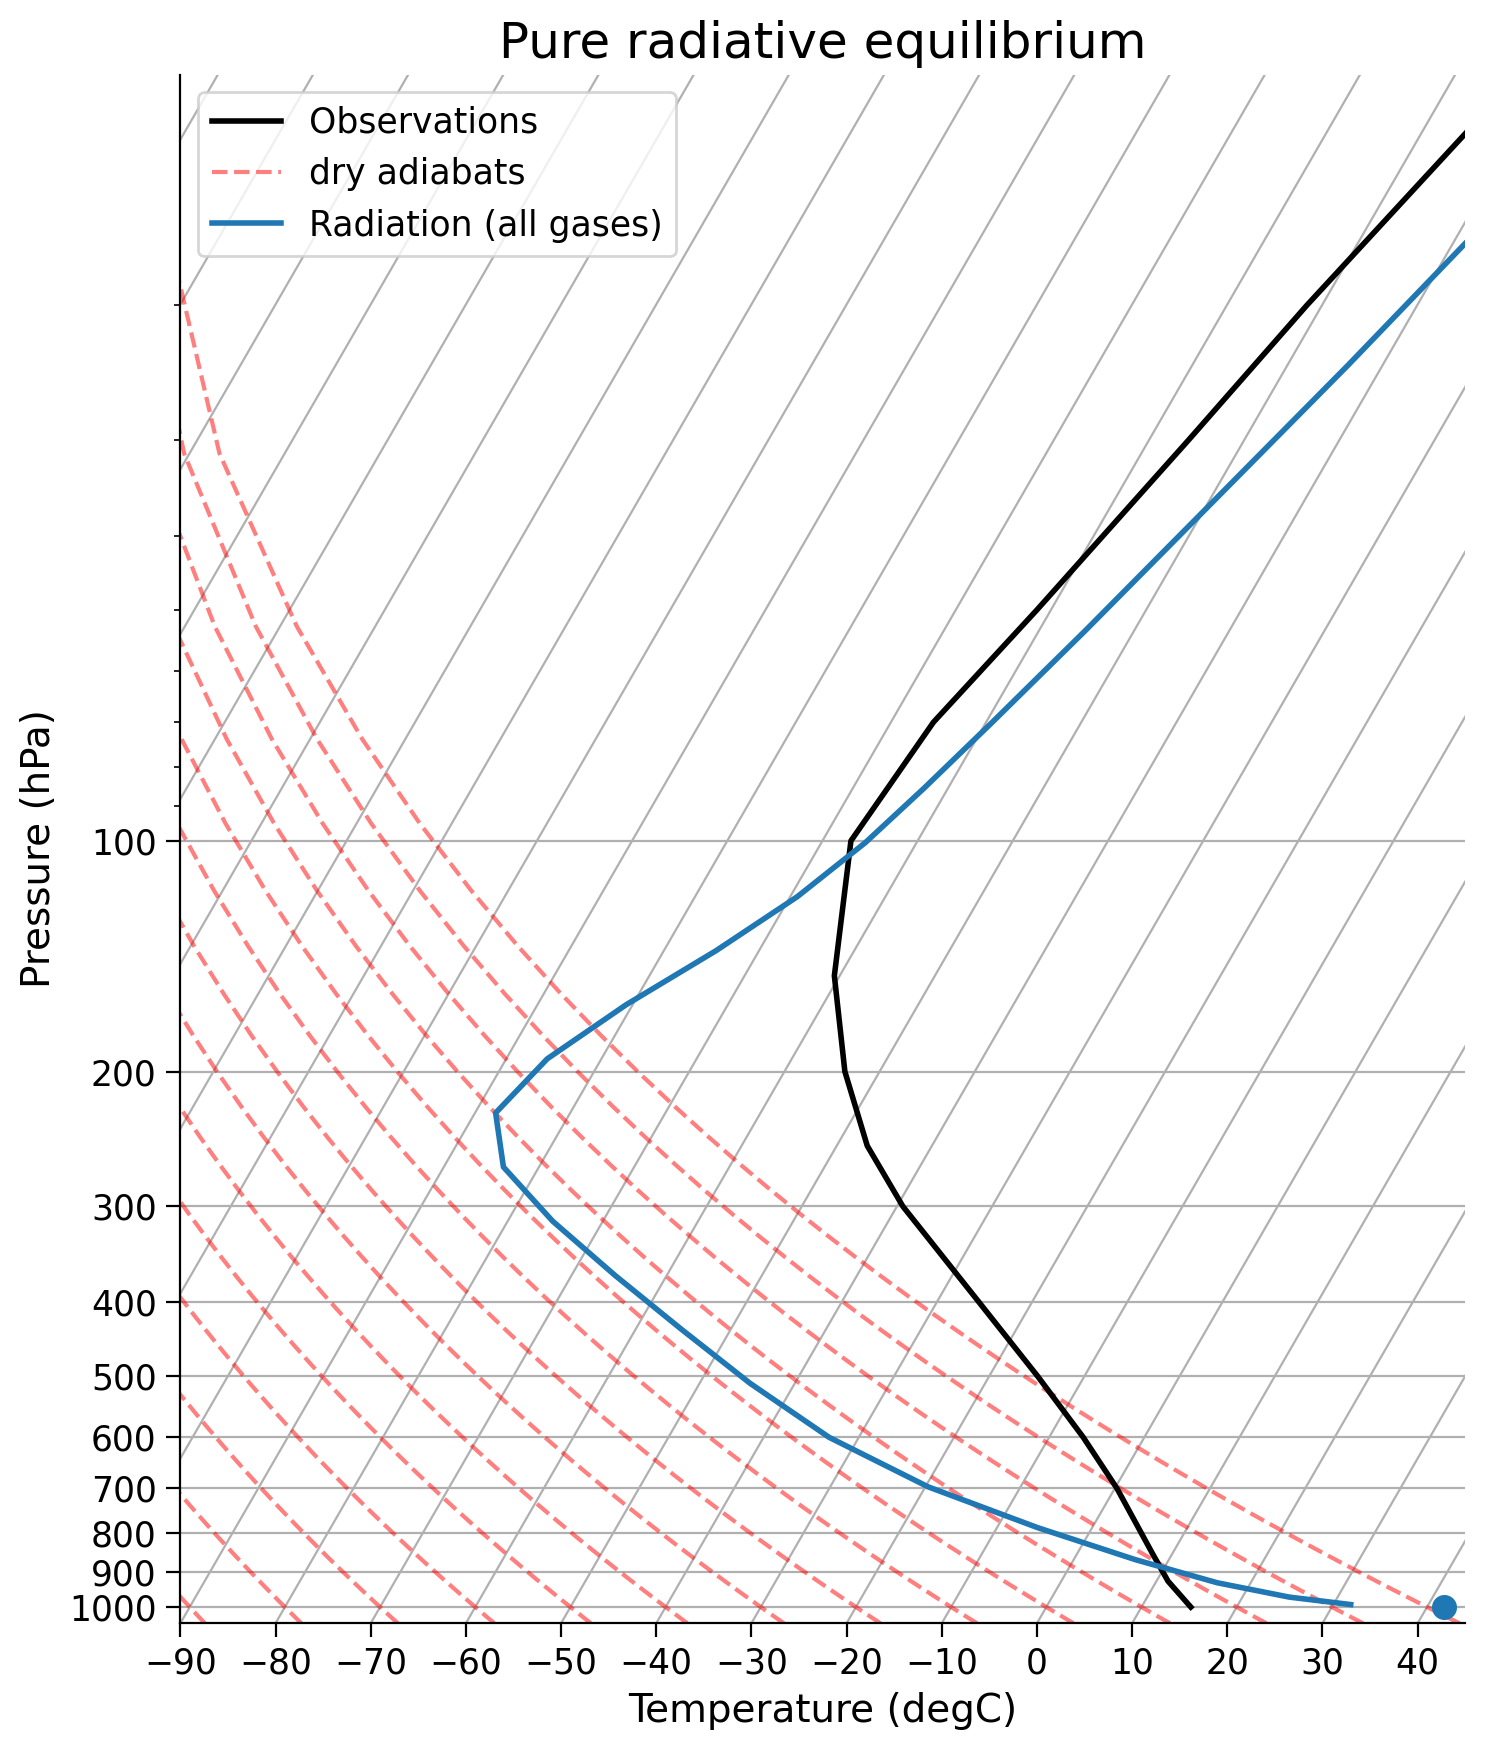

In [ ]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);



Near the surface, the observed temperature profile is steeper than the dry adiabats. In these layers vertical motion is inhibited, and the layer is considered stable. The model profile is shallower than the dry adiabats however. Here vertical motion is favored, and the layer is unstable. Thus, including physics in our model can reduce the instability seen here and bring us closer to the reanalysis tempearture profile.


To build a radiative-convective model we can take the radiative model we have already made and couple it to a convective model. Here the term **couple** implies there is communication between the models such that their effects are both incorporated into the final product, which in our case is the temperature profile.

In [ ]:
# restate the model here for ease of coding

# make a model on same vertical domain as the water vapor data
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

# create the radiation model
rad = climlab.radiation.RRTMG(name='Radiation (net)',
                              state=mystate, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # surface albedo, tuned to give reasonable ASR for reference cloud-free model
                             )

# create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,     # the adiabatic lapse rate of the atmopshere
                                               timestep=rad.timestep,  # same timestep as radiation model
                                              )
# couple the two components
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

Now let's run just the radiation part to equilibrium (this should give us the same profile as in the previous section) and then turn on the physics (convection) and run to equilibrium again.

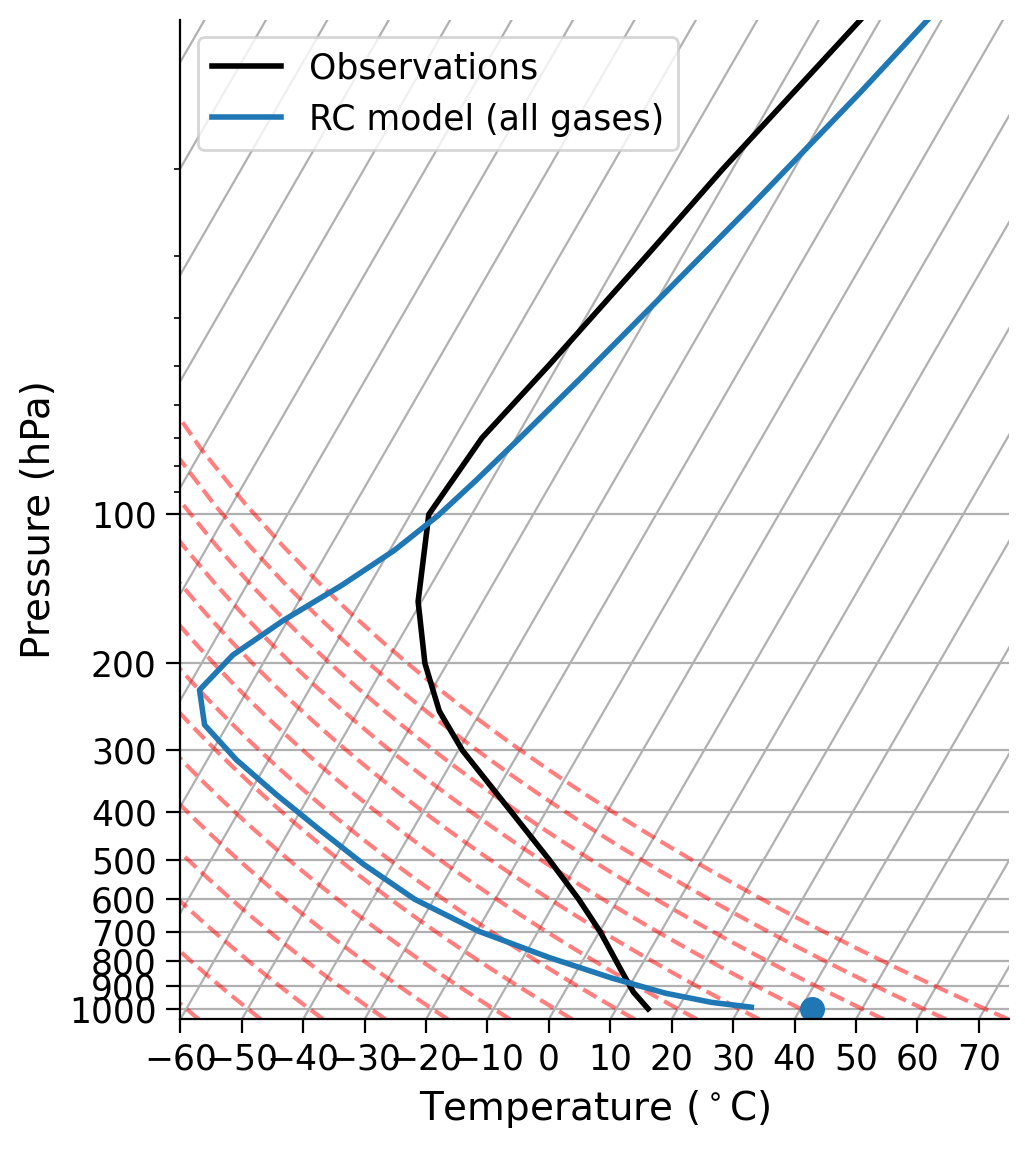

In [ ]:
# run JUST the radiative component to equilibrium
for n in range(1000):
    rcm.subprocess['Radiation (net)'].step_forward()

# compute diagnostics
rcm.compute_diagnostics()

#  plot the resulting profile (our initial condition once we turn on the physics)
fig, lines = initial_figure(rcm)

In [ ]:
# this animation can take a while
ani = animation.FuncAnimation(fig, animate, 100, fargs=(rcm, lines))
HTML(ani.to_html5_video())

## Questions

1. The instability was removed in the first time step! What does this mean about the time scales that convection and radiation act on? Which one is faster than the other?
2. Do you think the equilibrium temperature profile depends on the intial temperature profile?
3. What do you think the next step would be to move towards a more realistic climate model?

## Coding Exercises

1. Recreate the video above except using an isothermal atmosphere (uniform temperature profile) set to the surface temprature.

In [ ]:
# set initial temperature profile to be the surface temperature (isothermal)
rcm.state.Tatm[:] = rcm.state.Ts

# compute diagnostics
...

#  plot initial data
...

Ellipsis

In [ ]:
# make animation
...
...

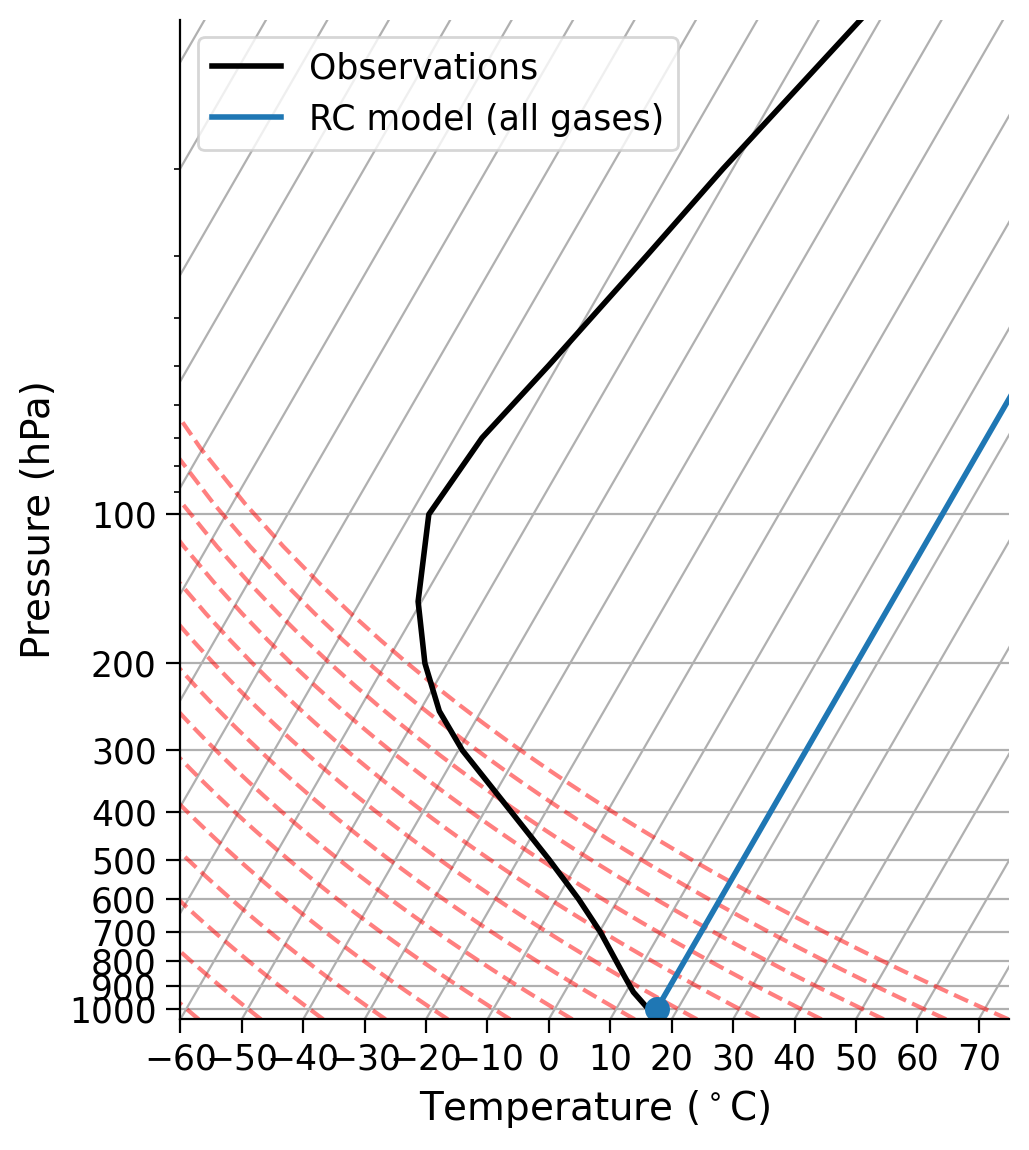

In [ ]:
# to_remove solution

# set initial temperature profile to be the surface temperature (isothermal)
rcm.state.Tatm[:] = rcm.state.Ts

# compute diagnostics
rcm.compute_diagnostics()

#  plot initial data
fig, lines = initial_figure(rcm)

In [ ]:
# make animation
ani = animation.FuncAnimation(fig, animate, 150, fargs=(rcm, lines))
HTML(ani.to_html5_video())